In [1]:
%matplotlib inline

import material_interface as mi

ni_poscar = """Ni - primitive
1.0
   2.130422000	   0.000000000	   1.230000000
   0.710140800	   2.008582000	   1.230000000
   0.000000000	   0.000000000	   2.460000000
Ni
1
Selective dynamics
cartesian
   0.000000000    0.000000000    0.000000000 T T T Ni"""
au_poscar = """Au - primitive
1.0
   2.554775000	   0.000000000	   1.475000000
   0.851591600	   2.408665000	   1.475000000
   0.000000000	   0.000000000	   2.950000000
Au
1
Selective dynamics
cartesian
   0.000000000    0.000000000    0.000000000 T T T Au"""

graphene_poscar = """Graphene
1.0
   2.467291000	   0.000000000	   0.000000000
  -1.233645000	   2.136737000	   0.000000000
   0.000000000	   0.000000000	   7.803074000
C
2
direct
   0.000000000    0.000000000    0.000000000  C
   0.333333000    0.666667000    0.000000000  C
"""

from ase.build import surface, supercells
from ase.io import read, write
from ase.visualize import view
import io
import numpy as np


def func():
    ni = mi.poscar_to_atoms(ni_poscar)
    gr = mi.poscar_to_atoms(graphene_poscar)

    print(ni.get_cell())
    print(gr.get_cell())

    ni_surface = surface(ni, (1, 1, 0), layers=3)
    ni_surface.center(vacuum=10, axis=2)
    ni_surface.wrap()
    view(ni_surface * [3, 3, 1])

    gr.center(vacuum=10, axis=2)
    gr.wrap()
    view(gr)
    ni_slab = supercells.make_supercell(ni_surface, [[3, 0, 0], [0, 3, 0], [0, 0, 1]])
    ni_slab.center(vacuum=10, axis=2)
    ni_slab.wrap()

    view(ni_slab)

    print(mi.write_atoms_to_poscar(ni))


# func()

In [64]:
"""pymatgen"""
from pymatgen.analysis.interfaces.zsl import ZSLGenerator
from pymatgen.core.structure import Structure
from coherent_interface_builder import CoherentInterfaceBuilder
from operator import itemgetter
import time

substrate = Structure.from_str(au_poscar, fmt="poscar")
layer = Structure.from_str(graphene_poscar, fmt="poscar")
substrate_miller = (1, 1, 1)
layer_miller = (0, 0, 1)


time_zero = time.perf_counter()
log = [{"start": time_zero}]
zsl = ZSLGenerator(max_area=400, max_length_tol=0.01)
cib = CoherentInterfaceBuilder(
    substrate_structure=substrate,
    film_structure=layer,
    substrate_miller=substrate_miller,
    film_miller=layer_miller,
    zslgen=zsl,
)

log.append({"CIB": time.perf_counter() - time_zero})

log.append({"matches": time.perf_counter() - time_zero})
cib._find_terminations()
matches = cib.zsl_matches
terminations = cib.terminations
log.append({"terminations": time.perf_counter() - time_zero})

interfaces = list(cib.get_interfaces(terminations[0], gap=3.0, substrate_thickness=3, in_layers=True))
log.append({"interfaces": time.perf_counter() - time_zero})

print("Found {} interfaces".format(len(matches)))
print(f"Terminations ({len(terminations)}):", terminations)

interfaces_list = list(interfaces)
data = sorted(interfaces_list, key=itemgetter("von_mises_strain"))
log.append({"sort": time.perf_counter() - time_zero})
print(log)

Found 158 interfaces
Terminations (1): [('C_P6/mmm_2', 'Au_R-3m_1')]
[{'start': 1009495.775738778}, {'CIB': 15.952574147027917}, {'matches': 15.952607312006876}, {'terminations': 15.959108261042275}, {'interfaces': 18.76074190705549}, {'sort': 18.77686620107852}]


lenght: 158


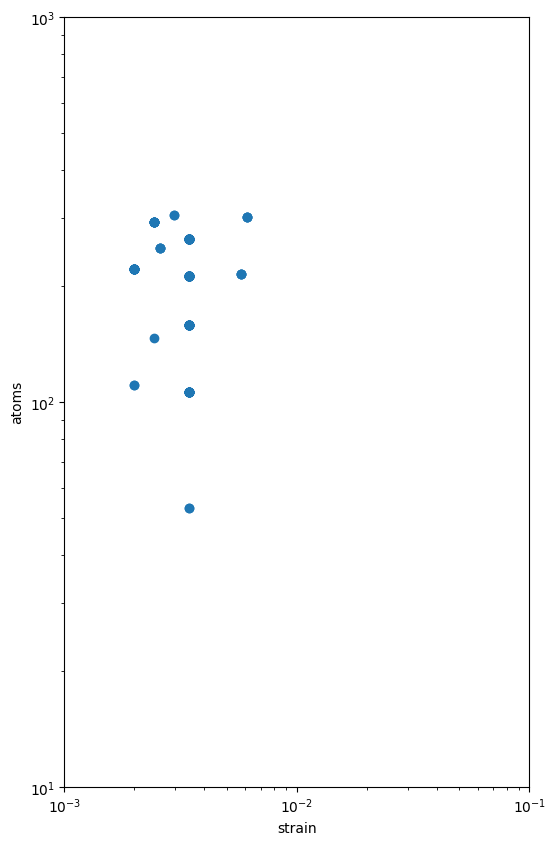

In [68]:
# map thru all interfaces and plot the strain vs number of atoms in the interface
strain = []
strain_von_mises = []
amount = []
print("lenght:", len(interfaces_list))
for i, object in enumerate(interfaces_list):
    strain_11 = object["strain"][0][0]
    strain_22 = object["strain"][1][1]
    strain_12 = object["strain"][0][1]
    strain_mean = (abs(strain_11) + abs(strain_22) + abs(strain_12)) / 3

    strain.append({"strain_11": strain_11, "strain_22": strain_22, "strain_12": strain_12, "strain_mean": strain_mean})
    strain_von_mises.append(object["von_mises_strain"])
    amount.append(object["interface"].num_sites)

strain_mean_values = [s["strain_mean"] for s in strain]

# plot the strain and strain_von_misses vs number of atoms in the interface with scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 10))
plt.plot(strain_mean_values, amount, "o")
plt.xlabel("strain")
plt.ylabel("atoms")
plt.xscale("log")
plt.yscale("log")
plt.xlim(left=0.001, right=0.1)
plt.ylim(bottom=10, top=1000)
plt.show()

In [67]:
data[0]["interface"].to(fmt="poscar")

'Au114 C108\n1.0\n  12.8587520081058884    0.0000000000000000    0.0000000000000008\n   0.0000001281287622   22.2720125729477090    0.0000000000000014\n   0.0000000000000000    0.0000000000000000   27.8173298503456650\nAu C\n114 108\ndirect\n   0.8684210477039526    0.0087719305084266    0.3188213121706132 Au\n   1.0789473634934263    0.0614035094557950    0.3188213121706132 Au\n   0.2631578898092156   -0.0175438589652575    0.3188213121706133 Au\n   0.4736842055986893    0.0350877199821109    0.3188213121706133 Au\n   0.6842105213881631    0.0877192989294793    0.3188213121706133 Au\n   0.8947368371776367    0.1403508778768477    0.3188213121706132 Au\n   1.1052631529671106    0.1929824568242161    0.3188213121706132 Au\n   0.2894736792828999    0.1140350884031636    0.3188213121706133 Au\n   0.4999999950723736    0.1666666673505320    0.3188213121706133 Au\n   0.7105263108618471    0.2192982462979003    0.3188213121706133 Au\n   0.9210526266513210    0.2719298252452688    0.318821312